# Preprocessing Notebook 2: Generate train and test data for SU2C NSCLC

This notebook is to create the train and test cohorts for the taux manuscript. We are using the count data from the SU2C study.

1. Remove outliers 
2. Cluster expression profiles
3. Stratify response and resistant cohorts by cluster

In [2]:
from datetime import datetime, timezone
import pandas as pd
import os
import numpy as np
import joblib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from bioinfokit.analys import norm as tpm_norm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from pyckmeans import MultiCKMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [3]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [4]:
lineage = "NSCLC"
today = datetime.now(timezone.utc).strftime("%Y-%m-%d")
VERSION = "V4"

In [5]:
tpm = pd.read_csv("../../data/expression/processed/SU2C-expression-tpm-ensembl.tsv",
                  sep='\t',
                  index_col=0)

In [6]:
tpm.shape

(57479, 152)

In [7]:
annot = pd.read_excel("../../data/clinical/original/SU2C-MARK_Supplementary_Tables_Combined_v5_Filtered.xlsx", sheet_name=1, header=2)
annot = annot[(annot["Harmonized_SU2C_RNA_Tumor_Sample_ID_v2"].isin(tpm.columns)) & (annot["Agent_PD1_Category"] == "PD(L)1") & (annot["Harmonized_Confirmed_BOR"] != "SD") & (annot["Pre-treatment_RNA_Sample_QC"] == "Keep")]
annot["batch"] = "SU2C " + annot["Institution"]
annot["sample"] = annot["Harmonized_SU2C_RNA_Tumor_Sample_ID_v2"]
annot["response"] = annot["Harmonized_Confirmed_BOR"].map({"PD": 0.0, "CR": 1.0, "PR": 1.0})
annot = annot[["sample", "batch", "response"]].dropna().set_index("sample")

In [8]:
annot

,batch,response
sample,,
SU2CLC-CLE-NIVO18-T1,SU2C Cleveland Clinic,0.0
SU2CLC-CLE-NIVO19-T1,SU2C Cleveland Clinic,1.0
SU2CLC-CLE-NIVO2-T1,SU2C Cleveland Clinic,0.0
SU2CLC-CLE-NIVO20-T1,SU2C Cleveland Clinic,1.0
SU2CLC-CLE-NIVO3-T1,SU2C Cleveland Clinic,1.0
...,...,...
SU2CLC-MGH-1575-T1,SU2C Massachusetts General Hospital,0.0
SU2CLC-MSK-1364-T1,SU2C Memorial Sloan Kettering,1.0
SU2CLC-UCD-1124-T1,SU2C UC Davis,1.0


In [9]:
tpm = tpm.reindex(annot.index.values, axis=1)

labels = annot["response"]

In [10]:
log2tpm1 = np.log2(tpm + 1.0)

In [11]:
log2tpm1 = log2tpm1[ log2tpm1.mean(axis=1) > 1.0 ]

In [21]:
tpm

,SU2CLC-CLE-NIVO18-T1,SU2CLC-CLE-NIVO19-T1,SU2CLC-CLE-NIVO2-T1,SU2CLC-CLE-NIVO20-T1,SU2CLC-CLE-NIVO3-T1,SU2CLC-CLE-NIVO5-T1,SU2CLC-COL-1005-T1,SU2CLC-COL-1017-T1,SU2CLC-COL-1021-T1,SU2CLC-COL-1025-T1,...,SU2CLC-MGH-1501-T1,SU2CLC-MGH-1565-T1,SU2CLC-MGH-1568-T1,SU2CLC-MGH-1572-T1,SU2CLC-MGH-1574-T1,SU2CLC-MGH-1575-T1,SU2CLC-MSK-1364-T1,SU2CLC-UCD-1124-T1,SU2CLC-UCD-1137-T1,SU2CLC-UCD-1142-T1
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,12.724300,12.748100,7.174090,4.809860,1.909720,2.6277,8.799990,24.381000,5.167380,22.320500,...,7.907970,20.710500,6.639700,4.314990,0.580286,14.480700,12.01440,9.169740,5.272020,6.457380
ENSG00000000005,0.578088,2.114820,0.535962,0.041432,0.234665,0.0000,0.058415,175.461000,0.140292,0.173823,...,0.375516,0.664281,0.180305,0.202235,0.072646,0.273955,0.00000,15.322300,0.254744,0.458305
ENSG00000000419,99.009700,71.046800,101.332000,44.212500,132.069000,120.3620,87.035800,85.014500,101.146000,119.964000,...,93.234900,97.960500,72.457800,86.781400,53.416800,92.966800,102.26800,41.566600,73.266800,112.790000
ENSG00000000457,11.115100,9.118390,15.731200,7.491410,37.591500,12.7974,7.105220,11.960000,15.070600,7.450730,...,11.534600,10.365300,9.554550,12.072200,10.985700,10.295600,5.70639,7.168080,8.345700,7.061920
ENSG00000000460,11.698400,13.135900,33.046500,15.203500,111.024000,19.0932,15.262300,39.304400,25.920100,24.343600,...,25.362400,19.474300,23.395900,14.863900,17.577300,21.647000,17.26320,4.918120,13.639700,13.579300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000284592,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
ENSG00000284594,0.000000,1.022380,0.310284,4.533390,1.410800,0.0000,2.130550,0.746246,0.000000,0.135852,...,0.266805,0.432643,5.380490,8.219000,5.961540,0.475801,5.00516,3.732530,3.045000,0.447737
ENSG00000284595,0.000000,0.433355,1.972790,0.000000,0.717590,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.100300,0.325803,0.000000,0.721974,0.806708,0.00000,0.000000,0.000000,0.569345


In [13]:
os.makedirs("pickles", exist_ok=True)

outliers = pd.DataFrame(index=log2tpm1.columns)

isofor_clf = IsolationForest(n_estimators = 100, contamination=0.02)
outliers["IsolationForest"] = isofor_clf.fit_predict(log2tpm1.T)
with open(f"pickles/{lineage}-isolation-forest-classifier.joblib", "wb") as f:
    joblib.dump(isofor_clf, f)

local_clf = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outliers["LocalOutlierFactor"] = local_clf.fit_predict(log2tpm1.T)

local_novelty_clf = LocalOutlierFactor(n_neighbors=20, contamination=0.02, novelty=True)
local_novelty_clf.fit(log2tpm1.T)
with open(f"pickles/{lineage}-local-outlier-factor-classifier.joblib", "wb") as f:
    joblib.dump(local_novelty_clf, f)

svm_clf = OneClassSVM(nu=0.02, kernel="linear")
outliers["OneClassSVM"] = svm_clf.fit_predict(log2tpm1.T)
with open(f"pickles/{lineage}-one-class-svm-classifier.joblib", "wb") as f:
    joblib.dump(svm_clf, f)

outlier_ensemble = outliers.sum(axis=1)
inliers = outlier_ensemble[outlier_ensemble > 0]

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [14]:
labels

sample
SU2CLC-CLE-NIVO18-T1    0.0
SU2CLC-CLE-NIVO19-T1    1.0
SU2CLC-CLE-NIVO2-T1     0.0
SU2CLC-CLE-NIVO20-T1    1.0
SU2CLC-CLE-NIVO3-T1     1.0
                       ... 
SU2CLC-MGH-1575-T1      0.0
SU2CLC-MSK-1364-T1      1.0
SU2CLC-UCD-1124-T1      1.0
SU2CLC-UCD-1137-T1      1.0
SU2CLC-UCD-1142-T1      1.0
Name: response, Length: 74, dtype: float64

Text(0.5, 1.0, 'Reanalyzed Inliers')

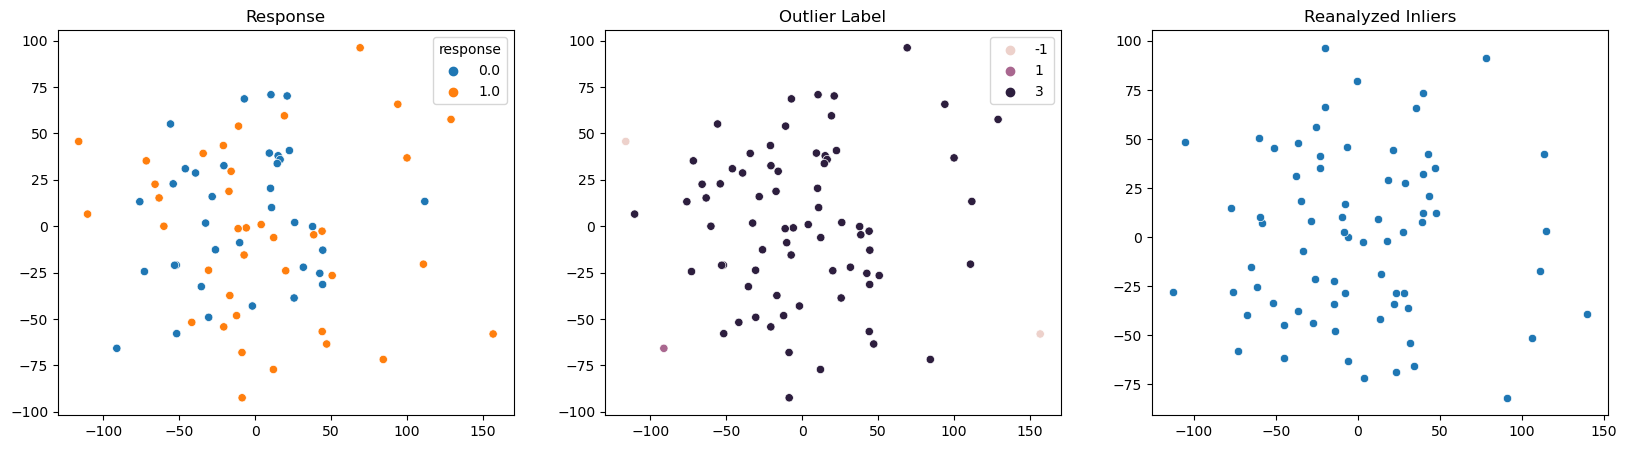

In [15]:
# PCA to check for outliers 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

sc = StandardScaler()
  
_X = sc.fit_transform(log2tpm1.T)
  
pca = PCA(n_components = 2)

_X = pca.fit_transform(_X)
  
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.scatterplot(x=_X[:, 0], y=_X[:, 1], hue=labels, ax=axes[0])
axes[0].set_title("Response")
sns.scatterplot(x=_X[:, 0], y=_X[:, 1], hue=outlier_ensemble, ax=axes[1])
axes[1].set_title("Outlier Label")
                

log2tpm1_inliers = log2tpm1.reindex(inliers.index, axis=1)
labels_inliers = labels.reindex(inliers.index)
assert list(log2tpm1_inliers.columns.values) == list(labels_inliers.index.values)

_X = sc.fit_transform(log2tpm1_inliers.T)
pca = PCA(n_components = 2)
_X = pca.fit_transform(_X)

sns.scatterplot(x=_X[:, 0], y=_X[:, 1], ax= axes[2])  
axes[2].set_title("Reanalyzed Inliers")

In [16]:
# Now need to find response correlation signals 

responder_log2tpm1_inliers = log2tpm1_inliers.loc[:, labels_inliers == 1]
non_responder_log2tpm1_inliers = log2tpm1_inliers.loc[:, labels_inliers == 0]

In [17]:
def search_sample_clusters(exp):
    mckm = MultiCKMeans(k=range(2, 8), n_rep=100, p_samp=0.8, p_feat=0.8)
    mckm.fit(exp)
    mckm_res = mckm.predict(exp, linkage_type="ward")

    # plot clustering metrics against k
    # BIC, DB: lower is better
    # SIL, CH: higher is better
    mckm_res.plot_metrics(figsize=(10,5))
    
    return mckm_res
    
def assign_sample_clusters(mckm_res, nclusters, prefix=""):
    study_clusters = pd.DataFrame()

    mckm_res_k = mckm_res.ckmeans_results[nclusters - 2]

    # plot consensus matrix and consensus clustering
    fig = mckm_res_k.plot(figsize=(7,7), )

    for sample, cluster in zip(mckm_res.names, mckm_res_k.cl):
        study_clusters.loc[sample, "cluster"] = f"{prefix}{cluster}"
        
    return study_clusters

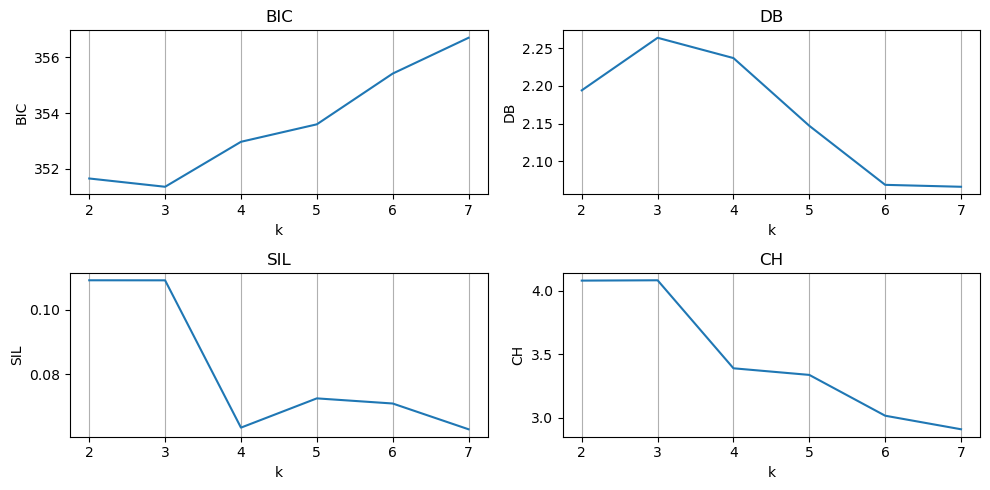

In [18]:
# This part requires manual intervention
responder_mckm_res = search_sample_clusters(responder_log2tpm1_inliers.T)

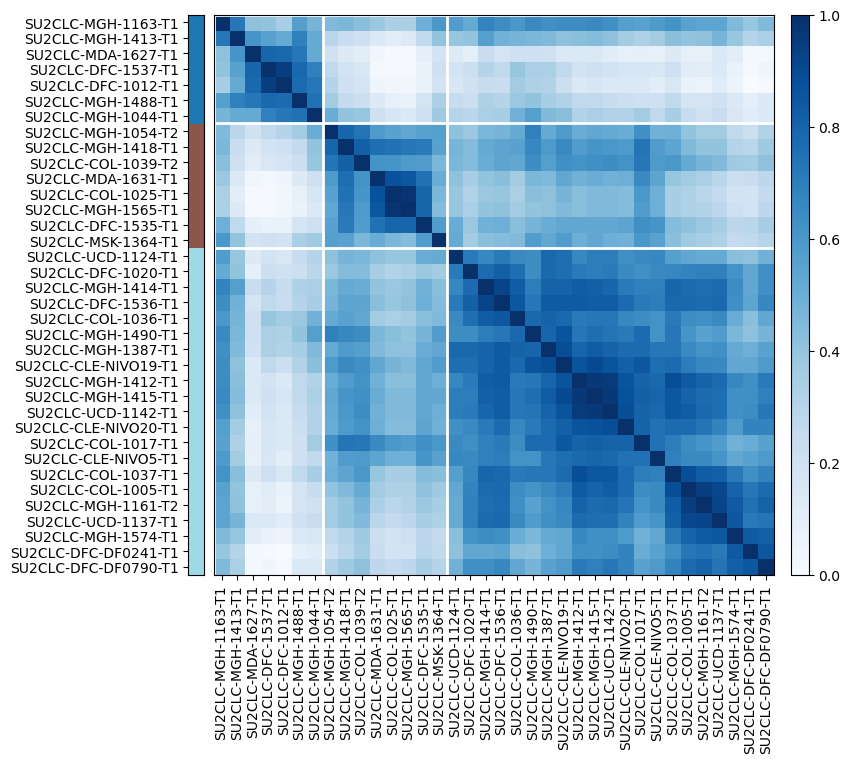

In [19]:
# This value is set based on the results from the previous clustering
responder_clusters = assign_sample_clusters(responder_mckm_res, 3, prefix=f"{lineage}-Response-Cluster-")

plt.savefig("../../figures/su2c/response-consensus-clusters.svg",
            format="svg",
            bbox_inches="tight")

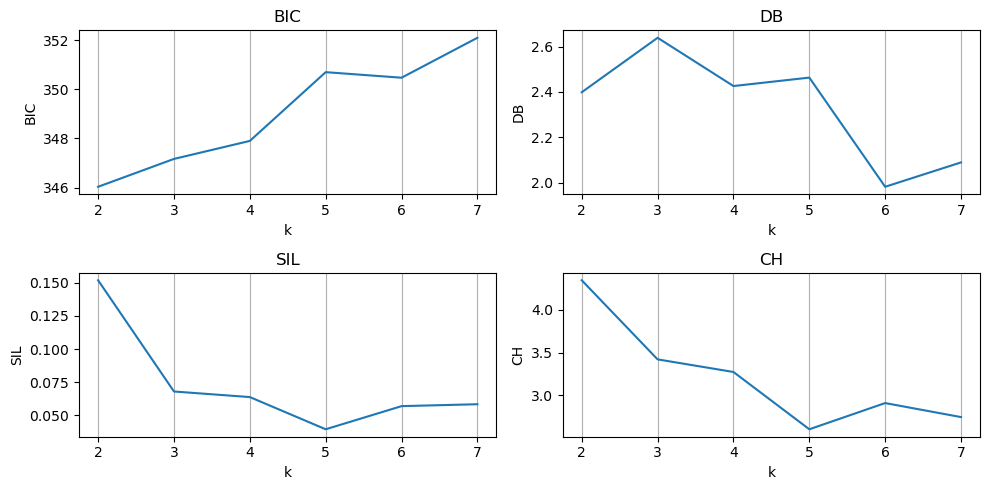

In [19]:
non_responder_mckm_res = search_sample_clusters(non_responder_log2tpm1_inliers.T)

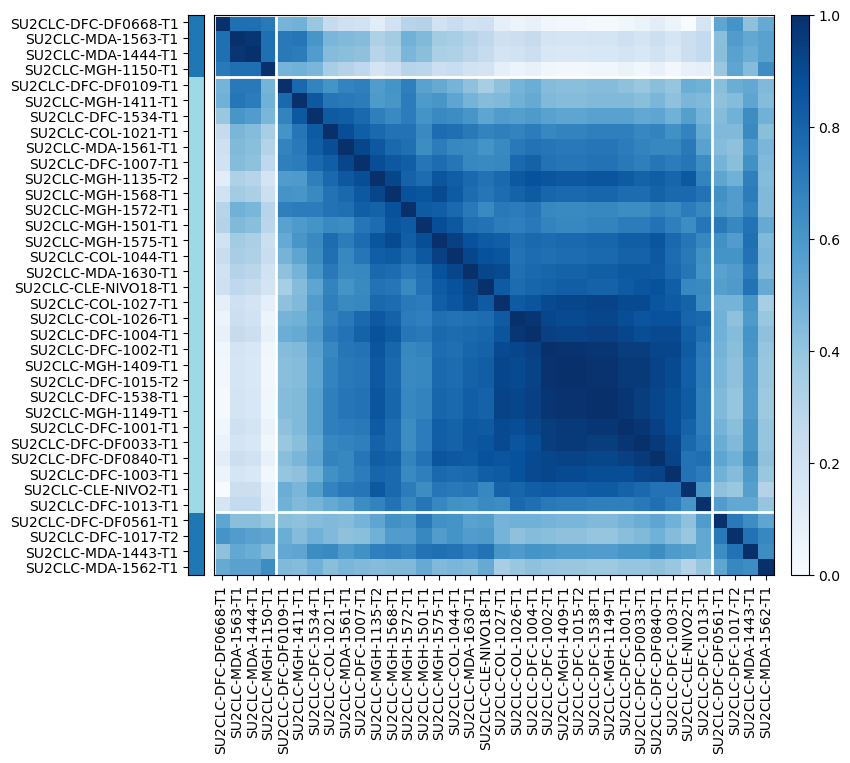

In [20]:
non_responder_clusters = assign_sample_clusters(non_responder_mckm_res, 2, prefix=f"{lineage}-Resistant-Cluster-")

In [21]:
clusters = pd.concat([responder_clusters, non_responder_clusters])

In [22]:
final_tpm = tpm.reindex(clusters.index, axis=1)

In [23]:
final_tpm = final_tpm.reindex(log2tpm1.index)

In [24]:
clusters["response"] = clusters.index.map(labels.to_dict())

In [25]:
scaler = preprocessing.MinMaxScaler(feature_range=(1, 100))
norm = pd.DataFrame(index=log2tpm1.index, columns=final_tpm.columns)

gene_bounds = pd.DataFrame(index=final_tpm.index, columns=['q1', 'q2', 'q3', 'upper_outlier', 'lower_outlier'])

for gene in norm.index.values:
    
    try:

        vec = final_tpm.loc[gene, :].values.reshape(-1, 1)
        q1 = np.percentile(vec, 25)
        q2 = np.percentile(vec, 50)
        q3 = np.percentile(vec, 75)

        upper_outlier = q3 + 1.5 * (q3 - q1)
        lower_outlier = q1 - 1.5 * (q3 - q1)

        gene_bounds.loc[gene, :] = [q1, q2, q3, upper_outlier, lower_outlier]

        idx, _ = np.where(vec > upper_outlier)
        vec[idx] = upper_outlier

        idx, _ = np.where(vec < lower_outlier)
        vec[idx] = lower_outlier

        norm.loc[gene, :] = scaler.fit_transform(vec).flatten()

    except Exception as e:
        print(e)
        continue

X_train, X_test, y_train, y_test = train_test_split(final_tpm.reindex(log2tpm1.index).T, 
                                                    clusters["response"].reindex(final_tpm.columns).astype(int),
                                                    train_size=0.80,
                                                    stratify=clusters["cluster"],
                                                    shuffle=True)

In [26]:
def save_all_samples():
    final_tpm.reindex(log2tpm1.index).to_csv(f"../../data/expression/processed/SU2C-NSCLC-TPM-{VERSION}-{today}.tsv", sep='\t')
    norm.reindex(log2tpm1.index).to_csv(f"../../data/expression/processed/SU2C-NSCLC-MinMaxNorm-TPM-{VERSION}-{today}.tsv", sep='\t')
    labels.reindex(final_tpm.columns).to_csv(f"../../data/expression/processed/SU2C-NSCLC-Labels-{VERSION}-{today}.tsv", header=None, sep='\t')
    
save_all_samples()

In [29]:
def save_train_test():

    os.makedirs(f"../../data/expression/processed/train/{VERSION}", exist_ok=True)
    os.makedirs(f"../../data/expression/processed/test/{VERSION}", exist_ok=True)

    X_train.T.to_csv(f"../../data/expression/processed/train/{VERSION}/IO-Atlas-{lineage}-TPM-TRAIN-{today}-{VERSION}.tsv",
                     sep='\t')


    y_train.to_csv(f"../../data/expression/processed/train/{VERSION}/IO-Atlas-{lineage}-LABEL-TRAIN-{today}-{VERSION}.tsv",
                   sep="\t",
                   header=None)
    
    clusters["cluster"].reindex(y_train.index).to_csv(f"../../data/expression/processed/train/{VERSION}/IO-Atlas-{lineage}-CLUSTERS-TRAIN-{today}-{VERSION}.tsv",
                   sep="\t",
                   header=None)

    norm.reindex(X_train.columns).reindex(X_train.index, axis=1).to_csv(f"../../data/expression/processed/train/{VERSION}/IO-Atlas-{lineage}-TPM-MinMaxNorm-TRAIN-{today}-{VERSION}.tsv",
                 sep='\t')

    X_test.T.to_csv(f"../../data/expression/processed/test/{VERSION}/IO-Atlas-{lineage}-TPM-TEST-{today}-{VERSION}.tsv",
                     sep='\t')


    y_test.to_csv(f"../../data/expression/processed/test/{VERSION}/IO-Atlas-{lineage}-LABEL-TEST-{today}-{VERSION}.tsv",
                  sep="\t",
                  header=None)
    
    clusters["cluster"].reindex(y_test.index).to_csv(f"../../data/expression/processed/test/{VERSION}/IO-Atlas-{lineage}-CLUSTERS-TEST-{today}-{VERSION}.tsv",
                   sep="\t",
                   header=None)

    norm.reindex(X_test.columns).reindex(X_test.index, axis=1).to_csv(f"../../data/expression/processed/test/{VERSION}/IO-Atlas-{lineage}-TPM-MinMaxNorm-TEST-{today}-{VERSION}.tsv",
                 sep='\t')

    train_counter = Counter(clusters.loc[y_train.index.values, "cluster"].values)
    test_counter = Counter(clusters.loc[y_test.index.values, "cluster"].values)

    print("Train vs Test")
    print("-------------")
    for cluster in sorted(train_counter.keys()):
        print(f"{cluster}: {train_counter[cluster] / train_counter.total()} vs {test_counter[cluster] / test_counter.total()}")
        
save_train_test()

Train vs Test
-------------
NSCLC-Resistant-Cluster-0: 0.10526315789473684 vs 0.13333333333333333
NSCLC-Resistant-Cluster-1: 0.38596491228070173 vs 0.4
NSCLC-Response-Cluster-0: 0.10526315789473684 vs 0.06666666666666667
NSCLC-Response-Cluster-1: 0.10526315789473684 vs 0.13333333333333333
NSCLC-Response-Cluster-2: 0.2982456140350877 vs 0.26666666666666666


In [32]:
def train_response_subtype_specific():
    
    os.makedirs(f"../../data/expression/processed/response-subtype-train/{VERSION}", exist_ok=True)
    os.makedirs(f"../../data/expression/processed/response-subtype-test/{VERSION}", exist_ok=True)
    
    for cluster, rows in responder_clusters.groupby("cluster"):

        subtype_clusters = pd.concat([rows, non_responder_clusters])


        X_train, X_test, y_train, y_test = train_test_split(final_tpm.reindex(log2tpm1.index).reindex(subtype_clusters.index.values, axis=1).T, 
                                                            clusters["response"].reindex(subtype_clusters.index.values).astype(int),
                                                            train_size=0.70,
                                                            stratify=subtype_clusters["cluster"],
                                                            shuffle=True)
        
        assert np.sum(y_test) > 1, "Need at least two samples..."
        
        print(y_test)
        
        #
        # Train
        #
        X_train.T.to_csv(f"../../data/expression/processed/response-subtype-train/{VERSION}/IO-Atlas-{lineage}-{cluster}-TPM-TRAIN-{today}-{VERSION}.tsv",
                     sep='\t')


        y_train.to_csv(f"../../data/expression/processed/response-subtype-train/{VERSION}/IO-Atlas-{lineage}-{cluster}-LABEL-TRAIN-{today}-{VERSION}.tsv",
                       sep="\t",
                       header=None)
        
        subtype_clusters["cluster"].reindex(y_train.index).to_csv(f"../../data/expression/processed/response-subtype-train/{VERSION}/IO-Atlas-{lineage}-{cluster}-CLUSTERS-TRAIN-{today}-{VERSION}.tsv",
                   sep="\t",
                   header=None)

        norm.reindex(X_train.columns).reindex(X_train.index, axis=1).to_csv(f"../../data/expression/processed/response-subtype-train/{VERSION}/IO-Atlas-{lineage}-{cluster}-TPM-MinMaxNorm-TRAIN-{today}-{VERSION}.tsv",
                     sep='\t')

        #
        # Test
        # 
        X_test.T.to_csv(f"../../data/expression/processed/response-subtype-test/{VERSION}/IO-Atlas-{lineage}-{cluster}-TPM-TEST-{today}-{VERSION}.tsv",
                         sep='\t')


        y_test.to_csv(f"../../data/expression/processed/response-subtype-test/{VERSION}/IO-Atlas-{lineage}-{cluster}-LABEL-TEST-{today}-{VERSION}.tsv",
                      sep="\t",
                      header=None)
        
        subtype_clusters["cluster"].reindex(y_test.index).to_csv(f"../../data/expression/processed/response-subtype-test/{VERSION}/IO-Atlas-{lineage}-{cluster}-CLUSTERS-TEST-{today}-{VERSION}.tsv",
                   sep="\t",
                   header=None)

        norm.reindex(X_test.columns).reindex(X_test.index, axis=1).to_csv(f"../../data/expression/processed/response-subtype-test/{VERSION}/IO-Atlas-{lineage}-{cluster}-TPM-MinMaxNorm-TEST-{today}-{VERSION}.tsv",
                     sep='\t')

        train_counter = Counter(subtype_clusters.loc[y_train.index.values, "cluster"].values)
        test_counter = Counter(subtype_clusters.loc[y_test.index.values, "cluster"].values)

        print("Train vs Test")
        print("-------------")
        for cluster in sorted(train_counter.keys()):
            print(f"{cluster}: {train_counter[cluster] / train_counter.total()} vs {test_counter[cluster] / test_counter.total()}")
        
train_response_subtype_specific()

SU2CLC-DFC-1002-T1      0
SU2CLC-DFC-DF0840-T1    0
SU2CLC-DFC-DF0033-T1    0
SU2CLC-MGH-1488-T1      1
SU2CLC-MGH-1575-T1      0
SU2CLC-CLE-NIVO18-T1    0
SU2CLC-COL-1021-T1      0
SU2CLC-MDA-1630-T1      0
SU2CLC-MGH-1501-T1      0
SU2CLC-DFC-DF0561-T1    0
SU2CLC-DFC-DF0668-T1    0
SU2CLC-DFC-1001-T1      0
SU2CLC-MDA-1627-T1      1
Name: response, dtype: int64
Train vs Test
-------------
NSCLC-Resistant-Cluster-0: 0.2 vs 0.15384615384615385
NSCLC-Resistant-Cluster-1: 0.6333333333333333 vs 0.6923076923076923
NSCLC-Response-Cluster-0: 0.16666666666666666 vs 0.15384615384615385
SU2CLC-COL-1025-T1      1
SU2CLC-DFC-1007-T1      0
SU2CLC-MGH-1501-T1      0
SU2CLC-DFC-1534-T1      0
SU2CLC-MDA-1444-T1      0
SU2CLC-CLE-NIVO18-T1    0
SU2CLC-DFC-1002-T1      0
SU2CLC-DFC-DF0033-T1    0
SU2CLC-MGH-1575-T1      0
SU2CLC-DFC-DF0561-T1    0
SU2CLC-MDA-1631-T1      1
SU2CLC-MDA-1561-T1      0
SU2CLC-DFC-1017-T2      0
SU2CLC-DFC-1538-T1      0
Name: response, dtype: int64
Train vs Test
-------